In [44]:
#On importe les packages utiles pour la suite et les signaux

import numpy as np
from matplotlib import pyplot as plt
from scipy import signal
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from mpl_toolkits.mplot3d import Axes3D
from sklearn import cluster
from sklearn.cluster import KMeans



data_brut=np.array(np.load("X.npy"))



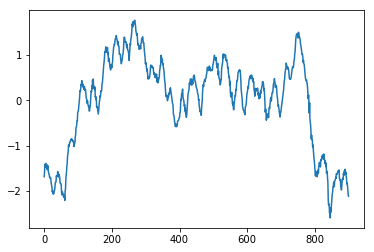

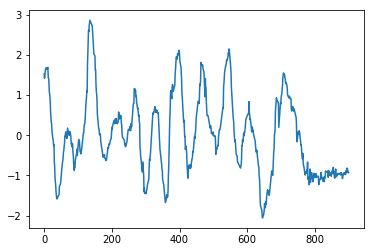

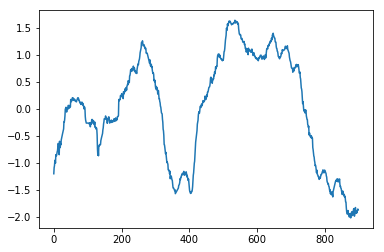

In [45]:
# Quelques signaux bruts

signals = [2,45,105]
t=[k for k in range(900)]
for x in signals:
    plt.figure()
    plt.plot(t,data_brut[x])
plt.show()


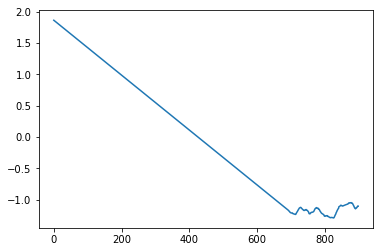

In [46]:
#Observation de signaux non utilisables

t=[k for k in range(900)]
plt.plot(t,data_brut[14])
plt.show()


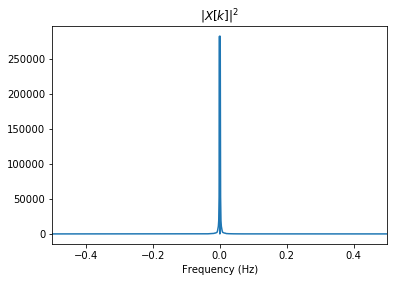

In [47]:
#On repère les signaux non utilisables en observant leur transformée de Fourier

Fs = 1

def my_fft(x,Fs):
    N=np.size(x)
    #Computation of the FFT
    X=np.fft.fft(x)
    X=np.fft.fftshift(X)
    # Computation the frequency vector
    f=np.fft.fftfreq(N, d=1/Fs)
    f=np.fft.fftshift(f)
    return X,f


X,f=my_fft(data_brut[14],Fs)
plt.plot(f,np.abs(X)**2)
plt.xlim((-Fs/2,Fs/2))
plt.xlabel('Frequency (Hz)')
plt.title('$|X[k]|^2$')
plt.show()

On observe que certains signaux ont une largeur de bande très faible : signaux inutilisables.
Regardons la fréquence max significative (>1000 Hz) 

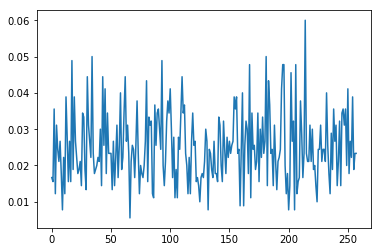

In [48]:
fmax =[0]*len(data_brut)
for k in range(len(data_brut)):
    X,f=my_fft(data_brut[k],Fs)
    max=0
    for i in range(len(data_brut[k])):
        if np.abs(X[i])**2>1000:
            max=i
    fmax[k]=f[max]
    
plt.plot([k for k in range(len(data_brut))],fmax)
plt.show()
  

    

On observe que la largeur de bande est très faible pour 7 signaux que nous représentons ci-dessous. On supprime ces signaux de la base de données car ils sont inutilisables. (On les réinclura à la fin).

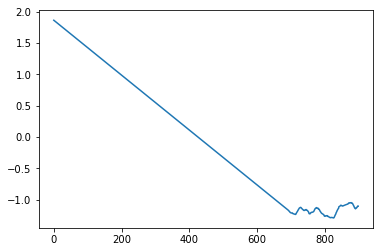

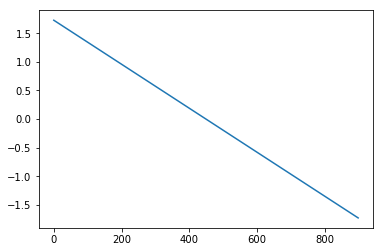

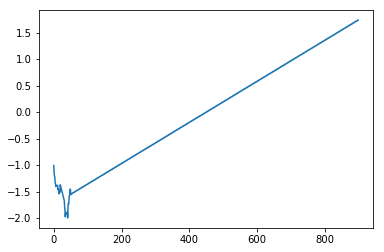

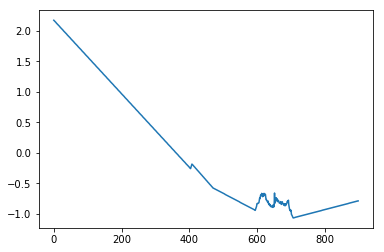

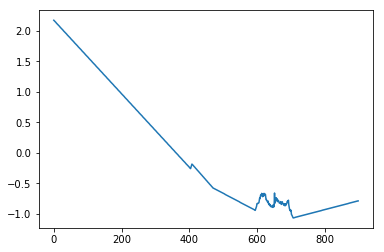

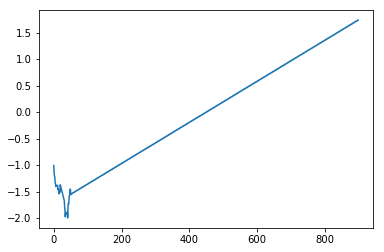

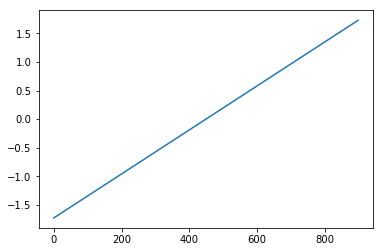

In [49]:
list=[14,56,124,126,136,187,212]

for x in list:
    plt.figure()
    plt.plot(t,data_brut[x])
    plt.show()

data = []
for k in range(len(data_brut)):
    if not (k in list):
        data.append(data_brut[k])


Les données ne sont pas propres, observons leur tranformée de Fourier pour appliquer un filtre passe-bas et débruiter un peu le signal.

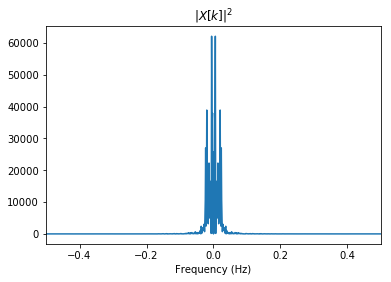

In [50]:
Fs = 1

def my_fft(x,Fs):
    N=np.size(x)
    #Computation of the FFT
    X=np.fft.fft(x)
    X=np.fft.fftshift(X)
    # Computation the frequency vector
    f=np.fft.fftfreq(N, d=1/Fs)
    f=np.fft.fftshift(f)
    return X,f

X,f=my_fft(data[12],Fs)
plt.plot(f,np.abs(X)**2)
plt.xlim((-Fs/2,Fs/2))
plt.xlabel('Frequency (Hz)')
plt.title('$|X[k]|^2$')
plt.show()

# à partir de 0.05Hz, on n'a plus de fréquences significatives

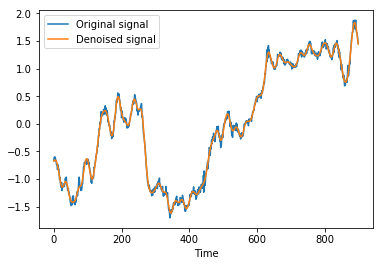

In [51]:
## Application du filtre passe-bas

data_filtre = []

def low_pass_filter(x,fc,Fs):
    wc=fc/(Fs/2)
    b, a = signal.butter(4, wc, 'lowpass')
    y = signal.filtfilt(b, a, x)
    return y


# Low-pass filter with cut frequency fc = 0.05 Hz
fc=0.05

for y in data:
    data_filtre.append(low_pass_filter(y,fc,Fs))

plt.figure()
plt.plot(t,data_brut[5])
plt.plot(t,data_filtre[5])
plt.xlabel('Time')
plt.legend(('Original signal', 'Denoised signal'))
plt.show()


On observe un signal bien plus propre, cependant les vers ont eu 30 minutes pour s'habituer, donc on ne devrait plus voir de tendances.

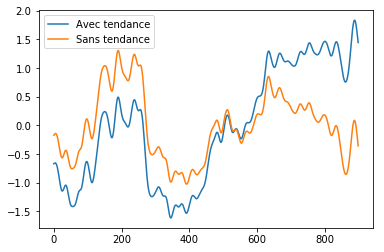

In [52]:
## On enlève la tendance: detrending en projetant sur 1, x, x^2, x^3, x^4 

data_clean=[]
t = [k for k in range(900)]

N=900
for y2 in data_filtre:
    D=np.zeros((N,4))
    D[:,0]=np.ones(N)
    D[:,1]=t
    D[:,2]=np.power(t,2)
    D[:,3]=np.power(t,3)
    alpha=np.dot(np.linalg.inv(np.dot(np.transpose(D),D)),np.dot(np.transpose(D),y2)) #Regression parameters
    x2_hat=np.dot(D,alpha); #Reconstruction
    data_clean.append(y2-x2_hat)

data_clean=np.array(data_clean)

plt.figure()
plt.plot(t,data_filtre[5])
plt.plot(t,data_clean[5])
plt.legend(("Avec tendance","Sans tendance"))
plt.show()
    

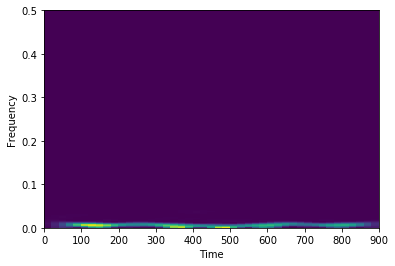

In [53]:
## Spectrogramme pour vérifier que stationnarité est ok

def my_spectrogram(x,Nw,No,Fs):
    f, t, Sxx = signal.stft(x, fs=Fs,nperseg=Nw, noverlap=No, nfft=4*Nw)
    return f,t,Sxx

x=data_clean[94]

Nw=200 # Window length
No=180 # Overlap length
f, t, Sxx = my_spectrogram(x,Nw,No,Fs)
plt.pcolormesh(t, f, np.abs(Sxx)**2)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

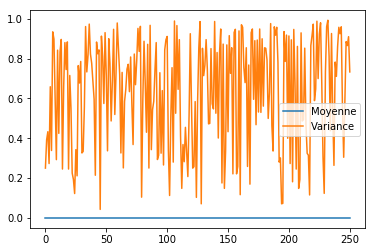

In [54]:
# Regardons les features classiques : moyenne, variance

n = len(data_clean)

Y = np.zeros((2,n))
for i in range(n):
    Y[0,i]=np.mean(data_clean[i,:])
    Y[1,i]=np.var(data_clean[i,:])

plt.figure()
plt.plot([k for k in range(n)],Y[0,:])
plt.plot([k for k in range(n)],Y[1,:])
plt.legend(('Moyenne','Variance'))
plt.show()

La moyenne est inutilisable, et la variance varie donc peut à priori être utilisé.

Utilisons PCA avec les features vues en cours : moyenne, variance, RMS, énergies ...

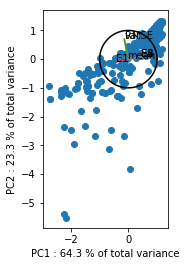

In [55]:
## PCA avec features vues en cours

def relative_energy(x,Nb,Fs):
    N=np.size(x)
    #Computation of the FFT
    X=np.fft.fft(x)
    f=np.fft.fftfreq(N, d=1/Fs)
    FNyq=Fs/2
    E=np.zeros((Nb,))
    for i in range(Nb):
        E[i]=np.sum(np.abs(X[(f>i*FNyq/Nb) & (f<=(i+1)*FNyq/Nb)])**2)
    E=E/np.sum(np.abs(X[(f>0) & (f<=Fs/2)])**2)
    return E

def compute_features(X):
    N,M=np.shape(X)
    Y=np.zeros((8,M))
    for i in range(M):
        Y[0,i]=np.mean(X[:,i])
        Y[1,i]=np.var(X[:,i])
        Y[2,i]=np.sqrt(np.sum(X[:,i]**2))
        E=relative_energy(X[:,i],5,1)
        Y[3:8,i]=E
    return Y



def my_pca(X):
    D,M=np.shape(X)
    X_=np.zeros((D,M))
    for d in range(D):
        X_[d,:]=(X[d,:]-np.mean(X[d,:]))/np.std(X[d,:])
    U,S,Vt=np.linalg.svd(X_)
    var_exp=S**2/(M-1)
    S2=np.zeros((D,M))
    S2[:D,:D]=np.diag(S)
    return U, np.dot(S2,Vt), var_exp

def plot_correlation_circle(U,feature_names,var_exp,X):
    N,M=np.shape(X)
    D,D=np.shape(U)
    Y= compute_features(X)
    Y_=np.zeros((D,M))
    for d in range(D):
        Y_[d,:]=(Y[d,:]-np.mean(Y[d,:]))/np.std(Y[d,:])
    Y_pca = np.zeros((2,M))
    D,D=np.shape(U)
    for m in range(M):
        f1=0
        f2=0
        for d in range(D):
            f1+=U[0,d]*Y_[d,m]
            f2+=U[1,d]*Y_[d,m]
        Y_pca[0,m]=f1
        Y_pca[1,m]=f2
    figure, axes = plt.subplots()
    plt.scatter(Y_pca[0,:],Y_pca[1,:])
    for d in range(D):
        plt.plot([0,U[d,0]],[0,U[d,1]])
        plt.text(U[d,0]+0.01, U[d,1]+0.01,feature_names[d])
    theta = np.linspace(0, 2*np.pi, 100)
    radius = 1
    a = radius*np.cos(theta)
    b = radius*np.sin(theta)
    axes.set_aspect(1)
    v=np.round(1000*var_exp/np.sum(var_exp))/10
    plt.plot(a,b,'k')
    plt.xlabel("PC1 : "+str(v[0])+" % of total variance")
    plt.ylabel("PC2 : "+str(v[1])+" % of total variance")
    plt.show()
    
Y = compute_features(np.transpose(data_clean))
D,M=np.shape(Y)
U,S_,var_exp=my_pca(Y)

feature_names = [
  'mean',
  'var',
  'RMSE',
  'E1', 'E2', 'E3', 'E4','E5']
plot_correlation_circle(U,feature_names,var_exp,np.transpose(data_clean))

On ne distingue pas vraiment 2 groupes...

On doit trouver 3 features: il peut donc être intéressant de tracer les points en fonction des 3 features du PCA

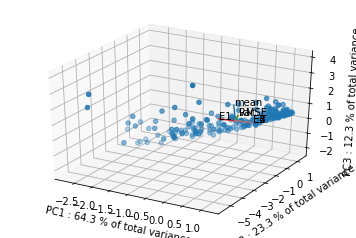

In [56]:
def plot_correlation_circle_3D(U,feature_names,var_exp,X):
    N,M=np.shape(X)
    D,D=np.shape(U)
    Y= compute_features(X)
    Y_=np.zeros((D,M))
    for d in range(D):
        Y_[d,:]=(Y[d,:]-np.mean(Y[d,:]))/np.std(Y[d,:])
    Y_pca = np.zeros((3,M))
    D,D=np.shape(U)
    for m in range(M):
        f1=0
        f2=0
        f3=0
        for d in range(D):
            f1+=U[0,d]*Y_[d,m]
            f2+=U[1,d]*Y_[d,m]
            f3+=U[2,d]*Y_[d,m]
        Y_pca[0,m]=f1
        Y_pca[1,m]=f2
        Y_pca[2,m]=f3
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(Y_pca[0,:],Y_pca[1,:],Y_pca[2,:])
    for d in range(D):
        ax.plot([0,U[d,0]],[0,U[d,1]],[0,U[d,2]])
        ax.text(U[d,0]+0.01, U[d,1]+0.01,U[d,2]+0.01,feature_names[d])
    v=np.round(1000*var_exp/np.sum(var_exp))/10
    ax.set_xlabel("PC1 : "+str(v[0])+" % of total variance")
    ax.set_ylabel("PC2 : "+str(v[1])+" % of total variance")
    ax.set_zlabel("PC3 : "+str(v[2])+" % of total variance")
    plt.show()
    
plot_correlation_circle_3D(U,feature_names,var_exp,np.transpose(data_clean))

Pas d'amélioration on ne distingue pas vraiment 2 groupes même en 3D.


En observant les signaux, trouvons des features qui semblent pertinentes.

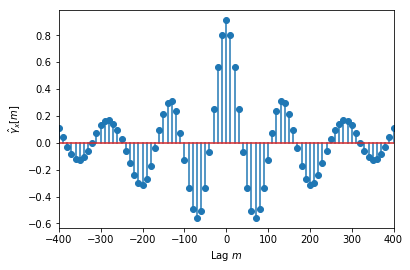

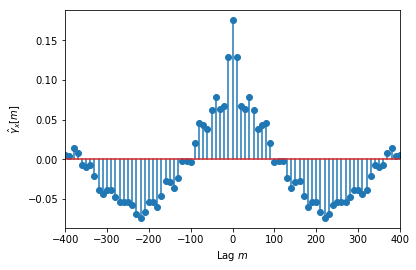

In [57]:
## Autocorrélation


# Biased estimator of the autocorrelation function
# lags are comprised between -maxLags and +maxLags
def autocorrelation(x,maxLags,n):
    N=len(x)
    gammax=np.correlate(x,x,'full')/N
    lags=np.arange(-maxLags,maxLags+1,n)
    gammax=gammax[N-maxLags-1:N+maxLags:n]
    return gammax,lags

#On calcule les lags par saut de 15 car le signal ne varie pas énormément pour des lags entre 1 et 10

x = data_clean[100]
y = data_clean[145]

# Plot the autocorrelation function
maxLags=400
gammax,lags=autocorrelation(x,maxLags,10)
plt.stem(lags,gammax,use_line_collection=True)
plt.xlabel('Lag $m$')
plt.xlim((-maxLags,maxLags))
plt.ylabel('$\hat{\gamma}_x[m]$')
plt.show()

gammax,lags=autocorrelation(y,maxLags,10)
plt.stem(lags,gammax,use_line_collection=True)
plt.xlabel('Lag $m$')
plt.xlim((-maxLags,maxLags))
plt.ylabel('$\hat{\gamma}_x[m]$')
plt.show()

On remarque que les fonctions d'autocorrélation séparent 2 groupes : pour certains signaux on a beaucoup de pics (positifs ou négatifs) donc des changements de signe, et pour d'autres beaucoup moins.

Plus haut nous avions constaté que la fréquence max varie beaucoup selon les signaux donc cela peut
être une bonne feature également. Aussi, les amplitudes des signaux semblent avoir 2 comportements différents selon les signaux donc on peut utiliser cette feature aussi.

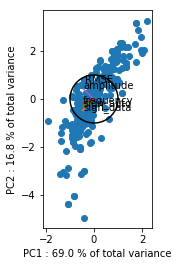

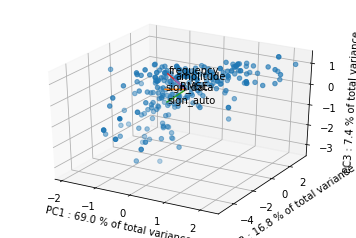

In [58]:
def sign_change(X):   #compte le nb de changements de signe
    c=0
    for k in range(len(X)-1):
        if X[k]*X[k+1] <= 0:
            c+=1
    return c

def max_frequency(X):
    x,f = my_fft(X,1)
    ind=0
    while np.abs(x[ind])**2<1000 and ind<899:
        ind+=1
    return -f[ind]



def compute_features_new(X):
    N,M=np.shape(X)
    Y=np.zeros((5,M))
    for i in range(M):
        Y[0,i]=np.sqrt(np.sum(X[:,i]**2))   #RMS
        Y[1,i]=sign_change(X[:,i])    #Nb de changements de signe du signal
        gammax,lags=autocorrelation(X[:,i],maxLags,10)
        Y[2,i]=sign_change(gammax)   #Nb de changements de signe de la fonction d'autocorrélation
        Y[3,i]=max_frequency(X[:,i])    #Fréquence max (>1000 Hz)
        Y[4,i]=np.max(X[:,i])          #Amplitude Max
    return Y

def my_pca(X):
    D,M=np.shape(X)
    X_=np.zeros((D,M))
    for d in range(D):
        X_[d,:]=(X[d,:]-np.mean(X[d,:]))/np.std(X[d,:])
    U,S,Vt=np.linalg.svd(X_)
    var_exp=S**2/(M-1)
    S2=np.zeros((D,M))
    S2[:D,:D]=np.diag(S)
    return U, np.dot(S2,Vt), var_exp

def plot_correlation_circle(U,feature_names,var_exp,X):
    N,M=np.shape(X)
    D,D=np.shape(U)
    Y= compute_features_new(X)
    Y_=np.zeros((D,M))
    for d in range(D):
        Y_[d,:]=(Y[d,:]-np.mean(Y[d,:]))/np.std(Y[d,:])
    Y_pca = np.zeros((2,M))
    D,D=np.shape(U)
    for m in range(M):
        f1=0
        f2=0
        for d in range(D):
            f1+=U[0,d]*Y_[d,m]
            f2+=U[1,d]*Y_[d,m]
        Y_pca[0,m]=f1
        Y_pca[1,m]=f2
    figure, axes = plt.subplots()
    plt.scatter(Y_pca[0,:],Y_pca[1,:])
    for d in range(D):
        plt.plot([0,U[d,0]],[0,U[d,1]])
        plt.text(U[d,0]+0.01, U[d,1]+0.01,feature_names[d])
    theta = np.linspace(0, 2*np.pi, 100)
    radius = 1
    a = radius*np.cos(theta)
    b = radius*np.sin(theta)
    axes.set_aspect(1)
    v=np.round(1000*var_exp/np.sum(var_exp))/10
    plt.plot(a,b,'k')
    plt.xlabel("PC1 : "+str(v[0])+" % of total variance")
    plt.ylabel("PC2 : "+str(v[1])+" % of total variance")
    plt.show()

def plot_correlation_circle_3D(U,feature_names,var_exp,X):
    N,M=np.shape(X)
    D,D=np.shape(U)
    Y= compute_features_new(X)
    Y_=np.zeros((D,M))
    for d in range(D):
        Y_[d,:]=(Y[d,:]-np.mean(Y[d,:]))/np.std(Y[d,:])
    Y_pca = np.zeros((3,M))
    D,D=np.shape(U)
    for m in range(M):
        f1=0
        f2=0
        f3=0
        for d in range(D):
            f1+=U[0,d]*Y_[d,m]
            f2+=U[1,d]*Y_[d,m]
            f3+=U[2,d]*Y_[d,m]
        Y_pca[0,m]=f1
        Y_pca[1,m]=f2
        Y_pca[2,m]=f3
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(Y_pca[0,:],Y_pca[1,:],Y_pca[2,:])
    for d in range(D):
        ax.plot([0,U[d,0]],[0,U[d,1]],[0,U[d,2]])
        ax.text(U[d,0]+0.01, U[d,1]+0.01,U[d,2]+0.01,feature_names[d])
    v=np.round(1000*var_exp/np.sum(var_exp))/10
    ax.set_xlabel("PC1 : "+str(v[0])+" % of total variance")
    ax.set_ylabel("PC2 : "+str(v[1])+" % of total variance")
    ax.set_zlabel("PC3 : "+str(v[2])+" % of total variance")
    plt.show()

 # Computation of PCA
Y = compute_features_new(np.transpose(data_clean))
D,M=np.shape(Y)
U,S_,var_exp=my_pca(Y)

feature_names = [
  'RMSE',
  'sign_data',
  'sign_auto', 'frequency', 'amplitude']
plot_correlation_circle(U,feature_names,var_exp,np.transpose(data_clean))
plot_correlation_circle_3D(U,feature_names,var_exp,np.transpose(data_clean))

Le résultat ne semble pas mieux que celui précédent en 2D, mais en 3D on semble distinguer 2 groupes.

On trace alors les signaux en fonction des 3 features principales du PCA, puis on utilise un algo kmeans pour les classifier.

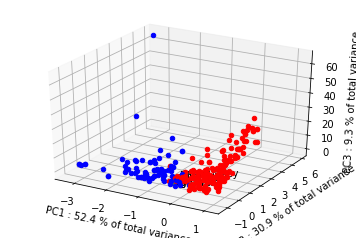

In [62]:
Y = compute_features_new(np.transpose(data_clean))
D,M=np.shape(Y)
U,S_,var_exp=my_pca(Y)

X = np.transpose(data_clean)

N,M=np.shape(X)
D,D=np.shape(U)
Y= compute_features_new(X)
Y_=np.zeros((D,M))
for d in range(D):
    Y_[d,:]=(Y[d,:]-np.mean(Y[d,:]))/np.std(Y[d,:])
Y_pca = np.zeros((3,M))
D,D=np.shape(U)
for m in range(M):
    f1=0
    f2=0
    f3=0
    for d in range(D):
        f1+=U[0,d]*Y_[d,m]
        f2+=U[1,d]*Y_[d,m]
        f3+=U[2,d]*Y_[d,m]
    Y_pca[0,m]=f1
    Y_pca[1,m]=f2
    Y_pca[2,m]=f3

kmeans = KMeans(n_clusters=2).fit(np.transpose(Y_pca))


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for k in range(len(Y_[0])):
    if kmeans.labels_[k]==0:
        ax.scatter(Y_[0,k],Y_[1,k],Y[2,k],color='blue')
    else:
        ax.scatter(Y_[0,k],Y_[1,k],Y[2,k],color='red')
for d in range(D):
    ax.plot([0,U[d,0]],[0,U[d,1]],[0,U[d,2]])
    ax.text(U[d,0]+0.01, U[d,1]+0.01,U[d,2]+0.01,feature_names[d])
v=np.round(1000*var_exp/np.sum(var_exp))/10
ax.set_xlabel("PC1 : "+str(v[0])+" % of total variance")
ax.set_ylabel("PC2 : "+str(v[1])+" % of total variance")
ax.set_zlabel("PC3 : "+str(v[2])+" % of total variance")
plt.show()

Ici, bien que la séparation ne soit pas évidente, on voit tout de même 2 groupes apparaître.

Ci-dessous, on applique tout ce qui précède à l'ensemble des signaux (même ceux inutilisables) afin de retourner un tableau Y_pca 3*N des features. (cela change la classification car les signaux inutilisables entraînent un déplacement des centres des classes pour l'algorithme kmeans).

In [68]:
data=np.array(np.load("X.npy"))

data_filtre=[]
for y in data:
    data_filtre.append(low_pass_filter(y,fc,Fs))
    
data_clean=[]
N=900
t = [k for k in range(900)]
for y2 in data_filtre:
    D=np.zeros((N,4))
    D[:,0]=np.ones(N)
    D[:,1]=t
    D[:,2]=np.power(t,2)
    D[:,3]=np.power(t,3)
    alpha=np.dot(np.linalg.inv(np.dot(np.transpose(D),D)),np.dot(np.transpose(D),y2)) #Regression parameters
    x2_hat=np.dot(D,alpha); #Reconstruction
    data_clean.append(y2-x2_hat)
data_clean=np.array(data_clean)

Y = compute_features_new(np.transpose(data_clean))
D,M=np.shape(Y)
U,S_,var_exp=my_pca(Y)

X = np.transpose(data_clean)

N,M=np.shape(X)
D,D=np.shape(U)
Y= compute_features_new(X)
Y_=np.zeros((D,M))
Y_=Y
Y_pca = np.zeros((3,M))
D,D=np.shape(U)
for m in range(M):
    f1=0
    f2=0
    f3=0
    for d in range(D):
        f1+=U[0,d]*Y_[d,m]
        f2+=U[1,d]*Y_[d,m]
        f3+=U[2,d]*Y_[d,m]
    Y_pca[0,m]=f1
    Y_pca[1,m]=f2
    Y_pca[2,m]=f3

Y_pca

array([[ -7.18220605,  -8.16784957,  -4.69952425,  -7.12813921,
        -10.6322822 ,  -6.43538357, -13.67570836, -13.01534758,
        -10.76063851,  -7.09892305, -13.34475798,  -8.52075407,
        -15.71561559, -14.01457785,   0.13960482,  -6.51936404,
        -11.04956869, -11.80137052, -12.24491231,  -9.92238821,
         -6.51936404, -12.76209619,  -8.70711393,  -5.42619197,
         -3.51021733,  -4.02814326,  -4.78064708,  -4.58936476,
        -11.45387547, -11.51323364, -12.71751869,  -7.65721401,
         -6.02568965, -10.87906332, -13.35090341, -13.0241354 ,
        -15.3370988 , -14.19353263, -13.22560224, -13.07834896,
        -13.01201093,  -7.57603926,  -6.65787663, -11.38986208,
        -13.24765127, -16.23875095,  -2.23424474, -12.94551662,
        -13.49783481, -10.05561396, -15.09444461, -11.53282059,
         -4.42174646, -13.87069583, -13.07834896,  -8.05848977,
          3.16256574, -13.06844439, -13.59499066, -10.28514733,
        -11.8111178 , -14.02070422, -10.